# Self-supervised Learning Model

# Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
IMG_SIZE = 96
BATCH_SIZE = 128
SSL_EPOCHS = 50
FINE_TUNING_EPOCHS = 30

# Dataset

In [ ]:
#Tfds
(train_ds, test_ds), ds_info = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

class_names = ds_info.features["label"].names
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Training examples: {ds_info.splits['train'].num_examples * 0.8}")
print(f"Testing examples: {ds_info.splits['train'].num_examples * 0.2}")


Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training examples: 40000.0
Testing examples: 10000.0


# Data exploration

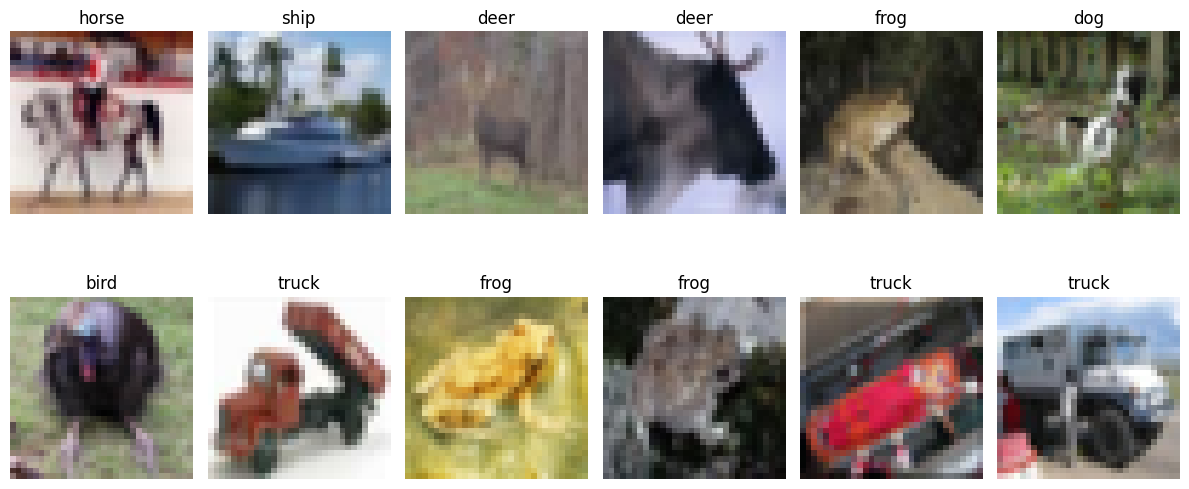

In [ ]:
def visualize_data_samples(train_ds, class_names):
    plt.figure(figsize=(12, 6))
    for i, (image, label) in enumerate(train_ds.take(12)):
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_data_samples(train_ds, class_names)

In [ ]:
def analyze_dataset_distribution(dataset, class_names, title="Dataset Class Distribution"):
    labels = []

    is_batched = False
    for data in dataset.take(1):
        if isinstance(data[1], tf.Tensor) and len(data[1].shape) > 0:
            is_batched = True
            break

    if is_batched:
        for _, batch_labels in dataset:
            for label in batch_labels:
                labels.append(label.numpy())
    else:
        for _, label in dataset:
            labels.append(label.numpy())

    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 5))
    plt.bar([class_names[u] for u in unique], counts)
    plt.title(f"{title}")
    plt.ylabel("Count")
    plt.grid(axis='y')
    plt.show()

# Data Preprocessing


In [ ]:
def augment(image, img_size=IMG_SIZE):
    original_size = tf.shape(image)[:2]
    crop_size = [tf.cast(tf.cast(original_size[0], tf.float32) * 0.8, tf.int32),
                 tf.cast(tf.cast(original_size[1], tf.float32) * 0.8, tf.int32),
                 3]
    image = tf.image.random_crop(image, size=crop_size)
    image = tf.image.resize(image, [img_size, img_size])

    # color transformations
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.1)

    # Random flips
    image = tf.image.random_flip_left_right(image)

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

In [ ]:
def create_pair_views(image, label):
    normalized_img = tf.cast(image, tf.float32) / 255.0
    view1 = augment(normalized_img, IMG_SIZE)
    view2 = augment(normalized_img, IMG_SIZE)
    return (view1, view2), label

def preprocess_image(image, label):
    image = tf.image.resize(tf.cast(image, tf.float32) / 255.0, [IMG_SIZE, IMG_SIZE])
    return image, label

def create_small_labeled_dataset(class_samples, num_classes, split=0.1):
  small_samples = []
  for class_idx in range(num_classes):
    small_samples.extend(class_samples[class_idx][:int(len(class_samples[class_idx]) * split)])

  np.random.shuffle(small_samples)

  train_ds_small = tf.data.Dataset.from_tensor_slices(
      ((tf.convert_to_tensor([item[0] for item in small_samples])),
        (tf.convert_to_tensor([item[1] for item in small_samples])))
  )

  labeled_train_ds_small = train_ds_small.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
  labeled_train_ds_small = labeled_train_ds_small.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return labeled_train_ds_small


ssl_train_ds = train_ds.map(create_pair_views, num_parallel_calls=tf.data.AUTOTUNE)
ssl_train_ds = ssl_train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_samples = list(train_ds.as_numpy_iterator())

class_samples = [[] for _ in range(num_classes)]
for item in train_samples:
    class_samples[item[1]].append(item)

labeled_train_ds_large = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
labeled_train_ds_large = labeled_train_ds_large.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds_processed = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_processed = test_ds_processed.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

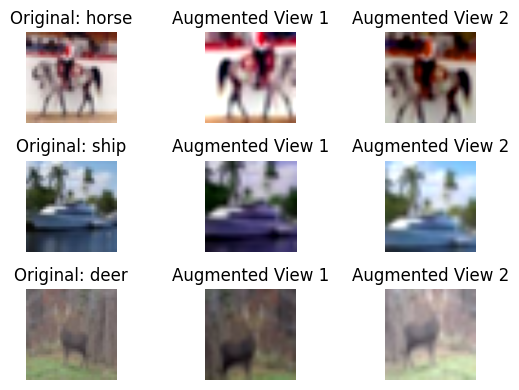

In [ ]:
def show_augmentation_examples(train_ds, class_names):
    plt.figure(figsize=(6, 4))
    for i, (image, label) in enumerate(train_ds.take(3)):
        normalized_img = tf.cast(image, tf.float32) / 255.0

        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(normalized_img.numpy())
        plt.title(f"Original: {class_names[label]}")
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        augmented1 = augment(normalized_img)
        plt.imshow(augmented1.numpy())
        plt.title("Augmented View 1")
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 3)
        augmented2 = augment(normalized_img)
        plt.imshow(augmented2.numpy())
        plt.title("Augmented View 2")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("Augmented_view.png")
    plt.show()

show_augmentation_examples(train_ds, class_names)

# Model Creation


In [ ]:
def create_encoder(img_size=IMG_SIZE, trainable=True):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = trainable

    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    features = base_model(inputs)
    features = tf.keras.layers.GlobalAveragePooling2D()(features)

    projection = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128)
    ])(features)

    encoder = tf.keras.Model(inputs, projection, name='encoder')
    return encoder, features

In [ ]:
class SelfSupervisedModel(tf.keras.Model):
    def __init__(self, img_size=IMG_SIZE):
        super(SelfSupervisedModel, self).__init__()
        self.encoder, _ = create_encoder(img_size=img_size, trainable=True)

    def compile(self, optimizer, temperature=0.1):
        super(SelfSupervisedModel, self).compile()
        self.optimizer = optimizer
        self.temperature = temperature
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def train_step(self, data):
        (view1, view2), _ = data

        with tf.GradientTape() as tape:
            z1 = self.encoder(view1, training=True)
            z2 = self.encoder(view2, training=True)

            loss = contrastive_loss((z1, z2), self.temperature)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker]

In [ ]:
def contrastive_loss(projections, temperature=0.1):
    projection_1, projection_2 = projections
    batch_size = tf.shape(projection_1)[0]

    projection_1 = tf.math.l2_normalize(projection_1, axis=1)
    projection_2 = tf.math.l2_normalize(projection_2, axis=1)

    representations = tf.concat([projection_1, projection_2], axis=0)

    similarity_matrix = tf.matmul(representations, representations, transpose_b=True)

    mask_pos = tf.eye(batch_size, dtype=tf.bool)
    mask_pos = tf.concat([tf.concat([tf.zeros_like(mask_pos), mask_pos], axis=1),
                         tf.concat([mask_pos, tf.zeros_like(mask_pos)], axis=1)], axis=0)

    mask_neg = ~mask_pos
    mask_neg = mask_neg & ~tf.eye(2*batch_size, dtype=tf.bool)

    positives = tf.boolean_mask(similarity_matrix, mask_pos) / temperature
    negatives = tf.boolean_mask(similarity_matrix, mask_neg) / temperature

    positives = tf.reshape(positives, [2*batch_size, 1])
    negatives = tf.reshape(negatives, [2*batch_size, 2*batch_size-2])

    logits = tf.concat([positives, negatives], axis=1)
    labels = tf.zeros(2*batch_size, dtype=tf.int64)

    loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )

    return tf.reduce_mean(loss)

In [ ]:
def train_ssl_model(ssl_model, ssl_train_ds, ssl_epochs=SSL_EPOCHS):

    ssl_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        temperature=0.1
    )

    ssl_history = ssl_model.fit(
        ssl_train_ds,
        epochs=ssl_epochs,
        verbose=1
    )

    plt.figure(figsize=(10, 5))
    plt.plot(ssl_history.history['loss'], 'b-o')
    plt.title('Self-Supervised Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return ssl_model

In [ ]:
def create_classifier(num_classes):
    encoder, features = create_encoder(trainable=True)

    try:
        encoder.load_weights('ssl_encoder_weights.weights.h5')
        print("Successfully loaded SSL encoder weights.")
    except:
        print("Could not load encoder weights. Using initialzed weights.")

    for layer in encoder.layers:
        if isinstance(layer, tf.keras.Model):
            base_model = layer
            break

    for layer in base_model.layers[:20]:
        layer.trainable = False

    inputs = encoder.input
    x = features
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    loss = 'sparse_categorical_crossentropy'

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
def train_classifier(model, labeled_train_ds, test_ds, epochs=30):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=4,
        restore_best_weights=True
    )

    history = model.fit(
        labeled_train_ds,
        epochs=epochs,
        validation_data=test_ds,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'r-o')
    plt.plot(history.history['val_accuracy'], 'b-o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(['Training', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'r-o')
    plt.plot(history.history['val_loss'], 'b-o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(['Training', 'Validation'])

    plt.tight_layout()
    plt.show()

    evaluation = model.evaluate(test_ds, verbose=1)
    print(f"Test Accuracy: {evaluation[1]:.4f}")

    return history


In [ ]:
ssl_model = SelfSupervisedModel(img_size=IMG_SIZE)
ssl_model.summary()

Model: "self_supervised_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ (None, 128)                 │       2,619,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,840 (9.99 MB)

 Trainable params: 2,585,216 (9.86 MB)

 Non-trainable params: 34,624 (135.25 KB)

# Training

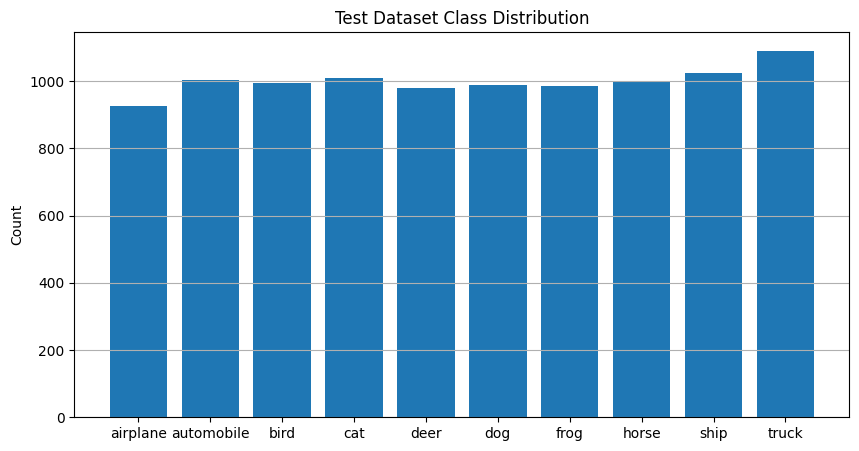

In [ ]:
analyze_dataset_distribution(test_ds_processed, class_names, "Test Dataset Class Distribution")

## Training Encoder

Epoch 1/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 189ms/step - loss: 0.7883
Epoch 2/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - loss: 0.1464
Epoch 3/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - loss: 0.1040
Epoch 4/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - loss: 0.0849
Epoch 5/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - loss: 0.0755
Epoch 6/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - loss: 0.0646
Epoch 7/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - loss: 0.0614
Epoch 8/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - loss: 0.0577
Epoch 9/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - loss: 0.0583
Epoch 10/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - loss: 0.0545
Epoch 11/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - loss: 0.0577
Epoch 12/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - loss: 0.0525
Epoch 13/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - loss: 0.0482
Epoch 14/75
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - loss: 0.0573
Epoch 15/75
313/313 ━━━━━━━

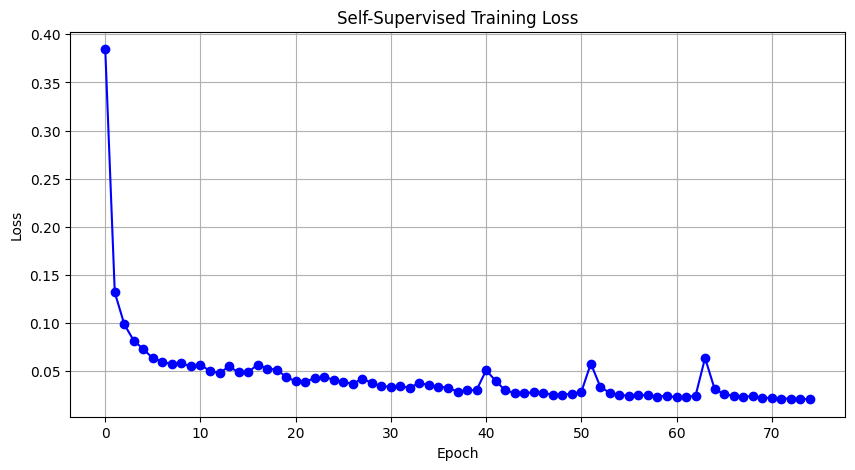

In [ ]:
ssl_model = train_ssl_model(ssl_model, ssl_train_ds, ssl_epochs=75)

# Save
ssl_model.encoder.save_weights('ssl_encoder_weights.weights.h5')

## Rebuild

In [ ]:
classifier = create_classifier(num_classes)
classifier.summary()

Successfully loaded SSL encoder weights.


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_19          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,589,514 (9.88 MB)

 Trainable params: 2,544,186 (9.71 MB)

 Non-trainable params: 45,328 (177.06 KB)

## Train on 20% label data

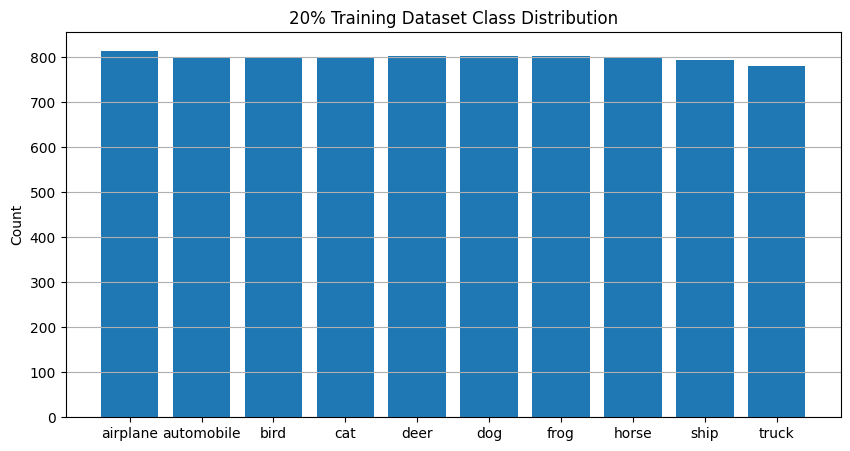

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 378ms/step - accuracy: 0.2231 - loss: 3.3610 - val_accuracy: 0.6428 - val_loss: 1.1199 - learning_rate: 1.0000e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5733 - loss: 1.5143 - val_accuracy: 0.7331 - val_loss: 0.8293 - learning_rate: 1.0000e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6768 - loss: 1.1195 - val_accuracy: 0.7670 - val_loss: 0.7271 - learning_rate: 1.0000e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7236 - loss: 0.9388 - val_accuracy: 0.7828 - val_loss: 0.6808 - learning_rate: 1.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7528 - loss: 0.8066 - val_accuracy: 0.7964 - val_loss: 0.6449 - learning_rate: 1.0000e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7746 - loss: 0.7352 - val_accuracy: 0.8062 - val_loss: 0.6228 - learning_rate: 1.0000e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.798

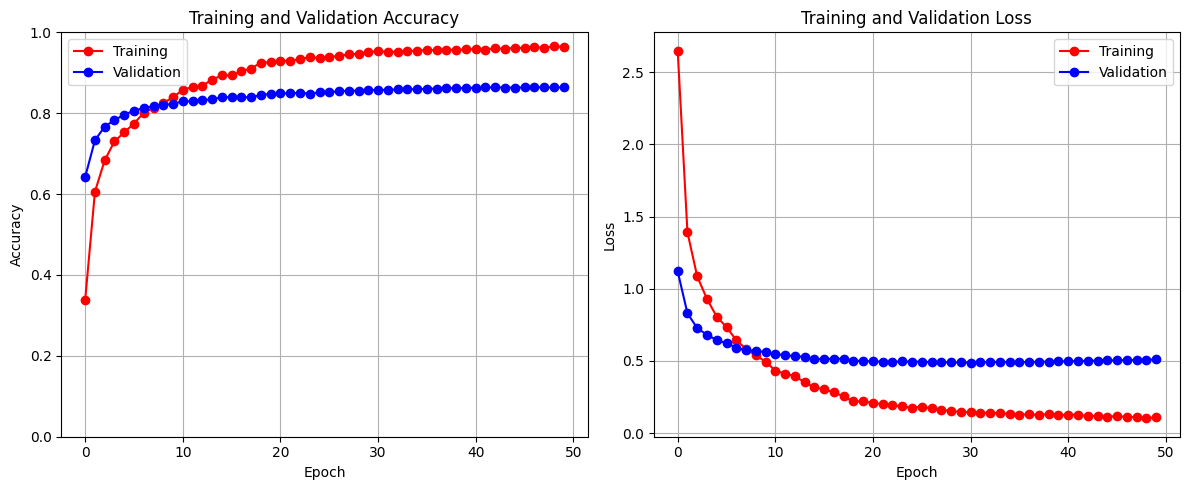

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8654 - loss: 0.5117
Test Accuracy: 0.8645


In [ ]:
labeled_train_ds_small = create_small_labeled_dataset(class_samples, num_classes, split=0.2)
analyze_dataset_distribution(labeled_train_ds_small, class_names, "20% Training Dataset Class Distribution")
history = train_classifier(classifier, labeled_train_ds_small, test_ds_processed, epochs=50)

# Evaluate

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step


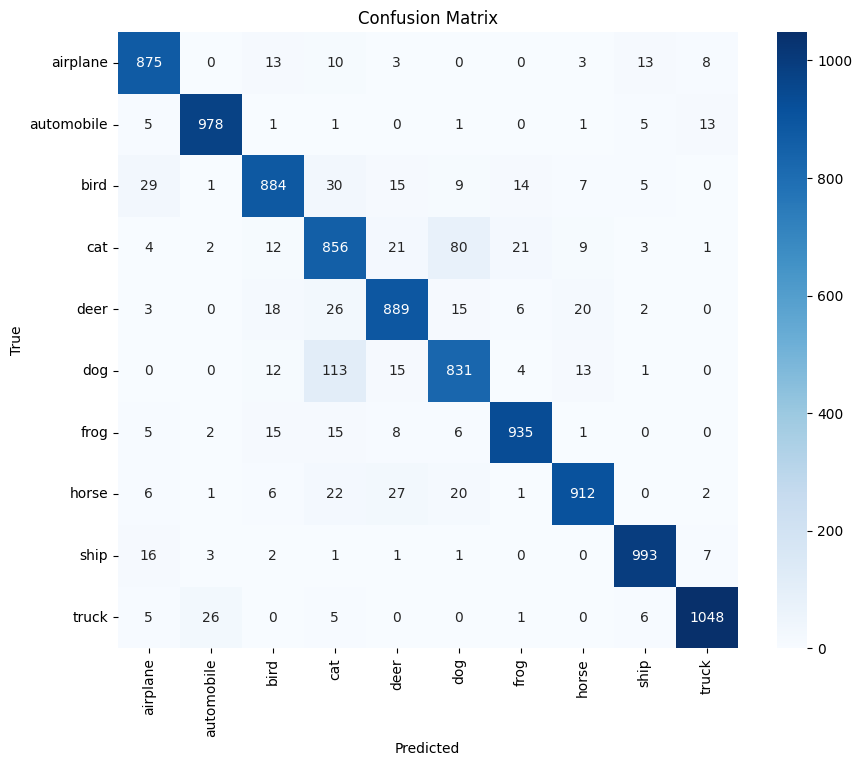

In [ ]:
def show_confusion_matrix(model, test_ds, class_names, num_classes):
    if num_classes == 2:
        y_pred_prob = model.predict(test_ds)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        y_pred = np.argmax(model.predict(test_ds), axis=1)

    y_true = []
    for _, y_batch in test_ds:
        y_true.append(y_batch.numpy())
    y_true = np.concatenate(y_true)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("Confusion_matrix.png")
    plt.show()

show_confusion_matrix(classifier, test_ds_processed, class_names, num_classes)

# Compare FT sizes

 * The same encoder as base

## 1%

Successfully loaded SSL encoder weights.


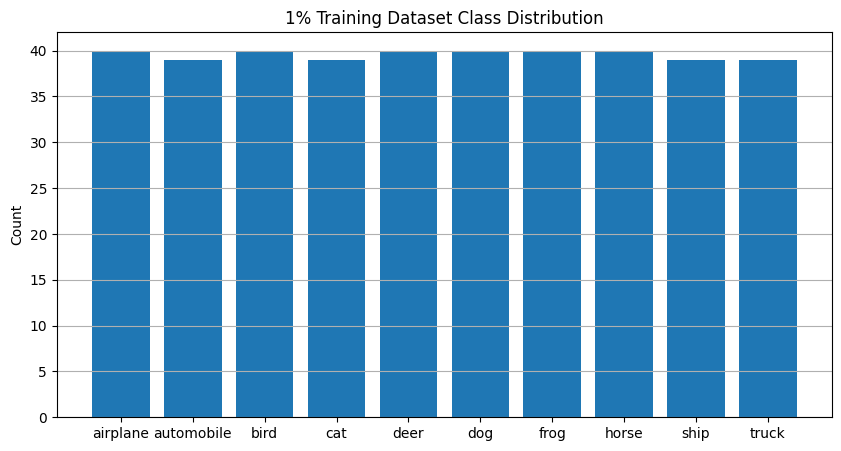

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.1013 - loss: 4.3499 - val_accuracy: 0.1065 - val_loss: 2.6856 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.1312 - loss: 3.9581 - val_accuracy: 0.1280 - val_loss: 2.5428 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - accuracy: 0.1408 - loss: 3.9761 - val_accuracy: 0.1528 - val_loss: 2.4161 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.1631 - loss: 3.3859 - val_accuracy: 0.1815 - val_loss: 2.2976 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - accuracy: 0.2309 - loss: 2.9152 - val_accuracy: 0.2141 - val_loss: 2.1902 - learning_rate: 1.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.2230 - loss: 2.7443 - val_accuracy: 0.2543 - val_loss: 2.0896 - learning_rate: 1.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - accuracy: 0.2688 - loss: 2

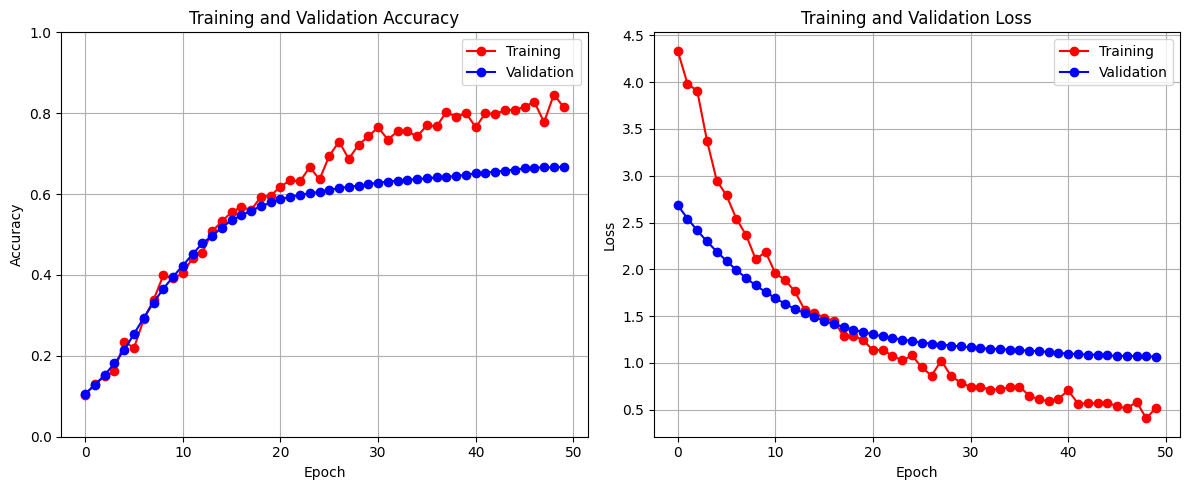

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6657 - loss: 1.0708
Test Accuracy: 0.6676


In [ ]:
classifier = create_classifier(num_classes)
labeled_train_ds_small = create_small_labeled_dataset(class_samples, num_classes, split=0.01)
analyze_dataset_distribution(labeled_train_ds_small, class_names, "1% Training Dataset Class Distribution")
history = train_classifier(classifier, labeled_train_ds_small, test_ds_processed, epochs=50)

## 5%

Successfully loaded SSL encoder weights.


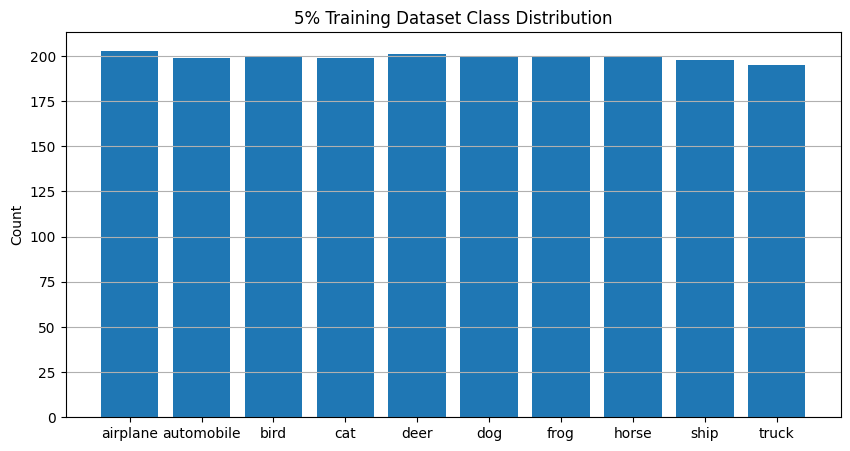

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.1366 - loss: 4.1684 - val_accuracy: 0.2975 - val_loss: 2.0159 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.2497 - loss: 2.7888 - val_accuracy: 0.5104 - val_loss: 1.5463 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.3942 - loss: 2.1256 - val_accuracy: 0.5950 - val_loss: 1.2726 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5218 - loss: 1.6609 - val_accuracy: 0.6355 - val_loss: 1.1302 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5639 - loss: 1.4805 - val_accuracy: 0.6640 - val_loss: 1.0314 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6332 - loss: 1.2271 - val_accuracy: 0.6826 - val_loss: 0.9628 - learning_rate: 1.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.

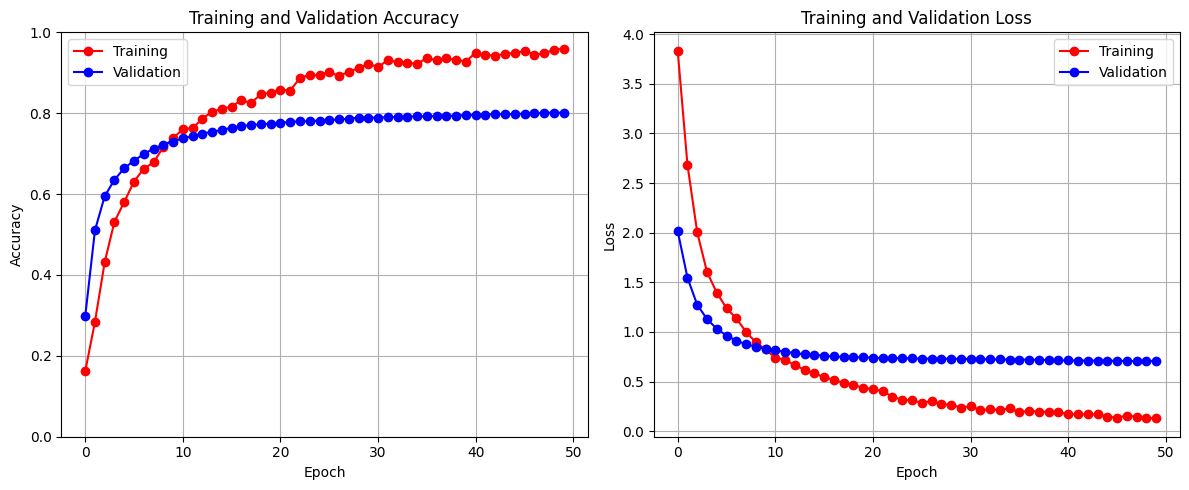

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8041 - loss: 0.7057
Test Accuracy: 0.8012


In [ ]:
classifier = create_classifier(num_classes)
labeled_train_ds_small = create_small_labeled_dataset(class_samples, num_classes, split=0.05)
analyze_dataset_distribution(labeled_train_ds_small, class_names, "5% Training Dataset Class Distribution")
history = train_classifier(classifier, labeled_train_ds_small, test_ds_processed, epochs=50)

## 10%

Successfully loaded SSL encoder weights.


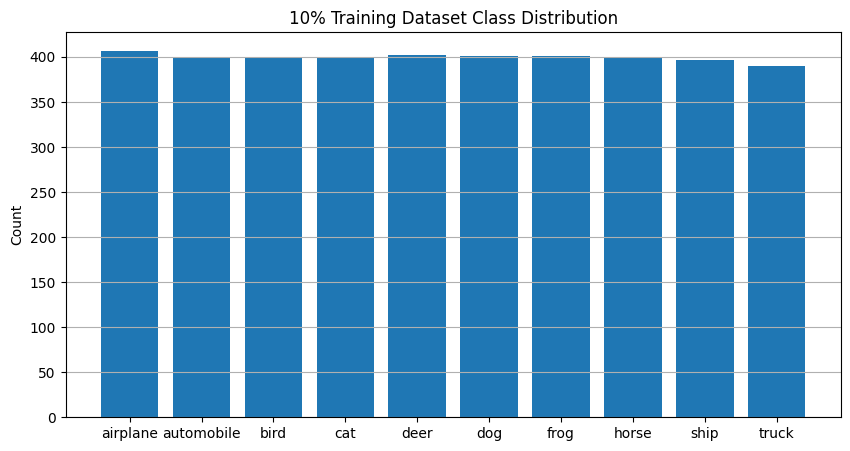

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 760ms/step - accuracy: 0.1443 - loss: 3.9322 - val_accuracy: 0.5354 - val_loss: 1.4778 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4033 - loss: 2.1777 - val_accuracy: 0.6511 - val_loss: 1.0690 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5548 - loss: 1.5963 - val_accuracy: 0.6965 - val_loss: 0.9175 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.6223 - loss: 1.2968 - val_accuracy: 0.7198 - val_loss: 0.8535 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.6807 - loss: 1.1260 - val_accuracy: 0.7339 - val_loss: 0.8153 - learning_rate: 1.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7176 - loss: 0.9415 - val_accuracy: 0.7473 - val_loss: 0.7823 - learning_rate: 1.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.744

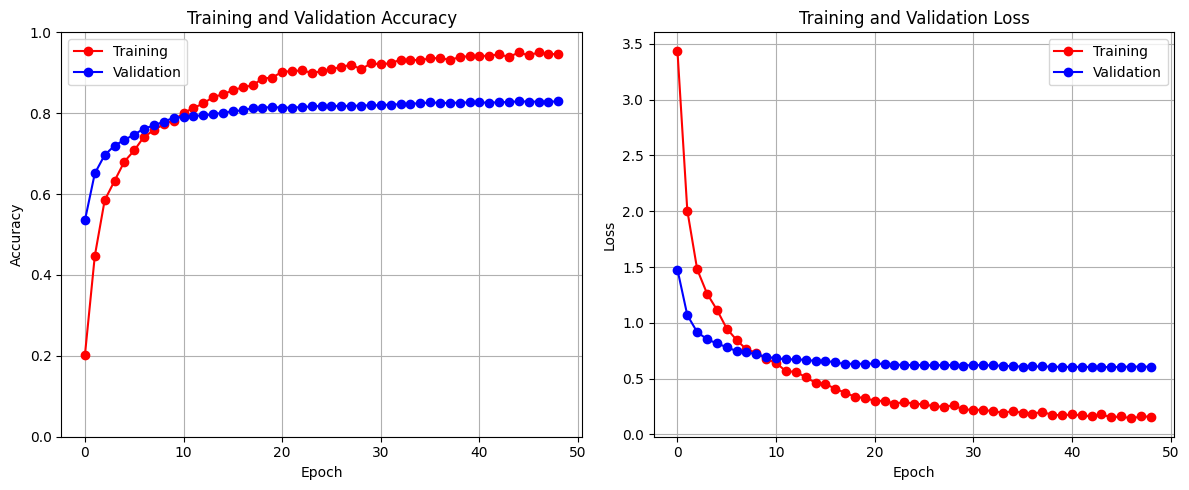

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8292 - loss: 0.6040
Test Accuracy: 0.8293


In [ ]:
classifier = create_classifier(num_classes)
labeled_train_ds_small = create_small_labeled_dataset(class_samples, num_classes, split=0.1)
analyze_dataset_distribution(labeled_train_ds_small, class_names, "10% Training Dataset Class Distribution")
history = train_classifier(classifier, labeled_train_ds_small, test_ds_processed, epochs=50)

## 30%

Successfully loaded SSL encoder weights.


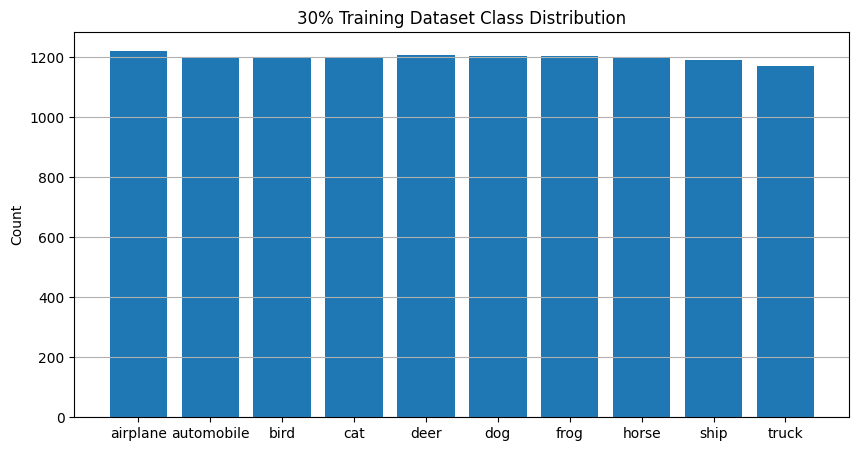

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 273ms/step - accuracy: 0.2543 - loss: 3.1790 - val_accuracy: 0.6903 - val_loss: 0.9472 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6380 - loss: 1.2677 - val_accuracy: 0.7666 - val_loss: 0.7302 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7156 - loss: 0.9568 - val_accuracy: 0.7955 - val_loss: 0.6554 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7694 - loss: 0.7638 - val_accuracy: 0.8101 - val_loss: 0.6181 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7764 - loss: 0.6937 - val_accuracy: 0.8211 - val_loss: 0.5750 - learning_rate: 1.0000e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8115 - loss: 0.6090 - val_accuracy: 0.8282 - val_loss: 0.5426 - learning_rate: 1.0000e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.820

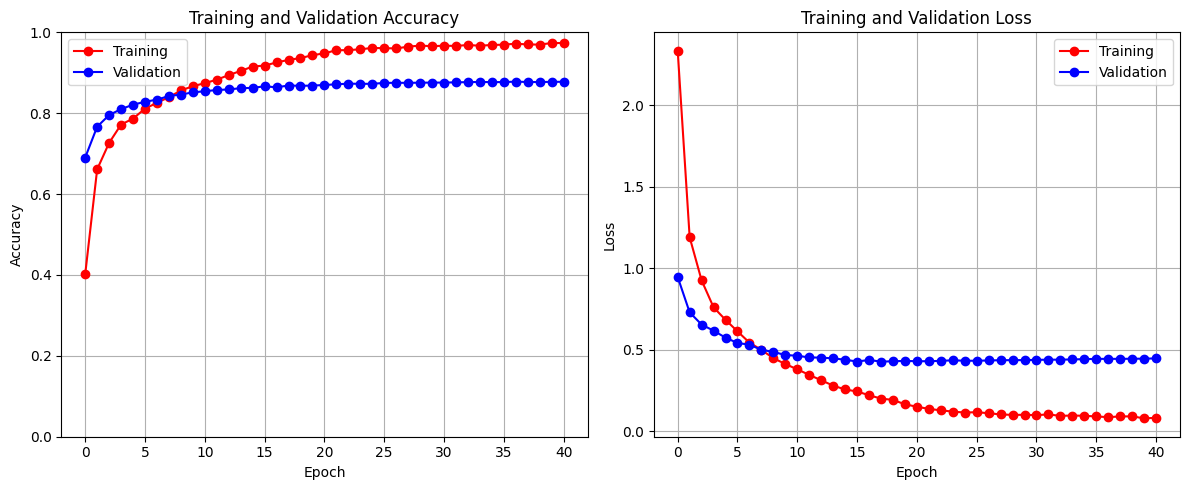

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8779 - loss: 0.4448
Test Accuracy: 0.8781


In [ ]:
classifier = create_classifier(num_classes)
labeled_train_ds_small = create_small_labeled_dataset(class_samples, num_classes, split=0.3)
analyze_dataset_distribution(labeled_train_ds_small, class_names, "30% Training Dataset Class Distribution")
history = train_classifier(classifier, labeled_train_ds_small, test_ds_processed, epochs=50)

## 50%

Successfully loaded SSL encoder weights.


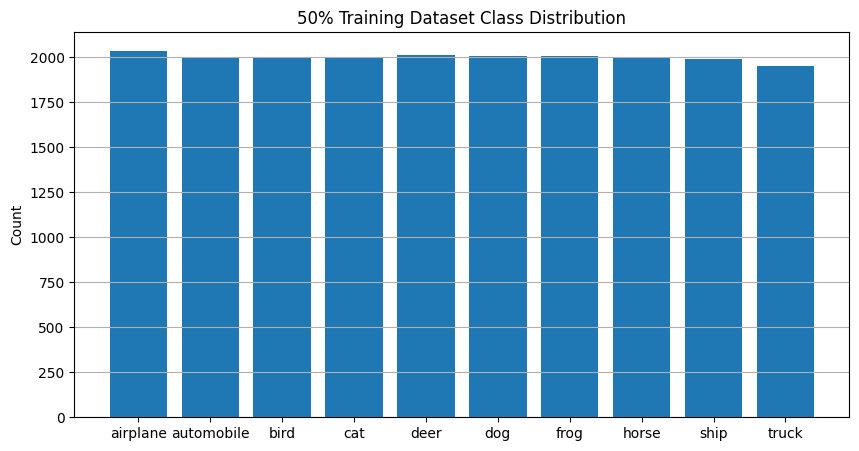

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 71s 175ms/step - accuracy: 0.3491 - loss: 2.6548 - val_accuracy: 0.7347 - val_loss: 0.7991 - learning_rate: 1.0000e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6958 - loss: 1.0326 - val_accuracy: 0.7940 - val_loss: 0.6439 - learning_rate: 1.0000e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7550 - loss: 0.8070 - val_accuracy: 0.8148 - val_loss: 0.5877 - learning_rate: 1.0000e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7933 - loss: 0.6553 - val_accuracy: 0.8307 - val_loss: 0.5445 - learning_rate: 1.0000e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8143 - loss: 0.5814 - val_accuracy: 0.8444 - val_loss: 0.4978 - learning_rate: 1.0000e-04
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8394 - loss: 0.5025 - val_accuracy: 0.8509 - val_loss: 0.4723 - learning_rate: 1.0000e-04
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - a

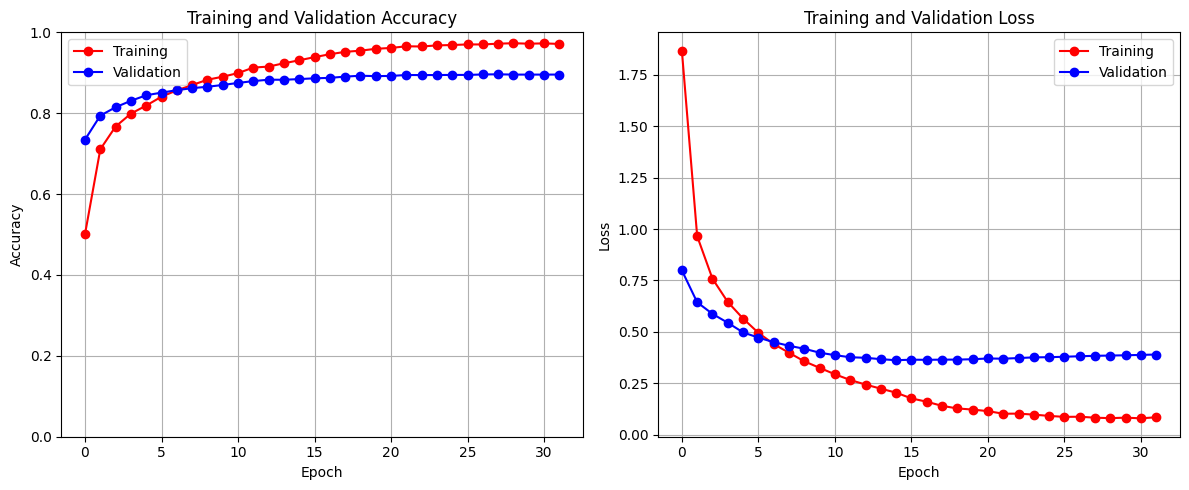

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8967 - loss: 0.3782
Test Accuracy: 0.8962


In [ ]:
classifier = create_classifier(num_classes)
labeled_train_ds_small = create_small_labeled_dataset(class_samples, num_classes, split=0.5)
analyze_dataset_distribution(labeled_train_ds_small, class_names, "50% Training Dataset Class Distribution")
history = train_classifier(classifier, labeled_train_ds_small, test_ds_processed, epochs=50)

## 100%

Successfully loaded SSL encoder weights.


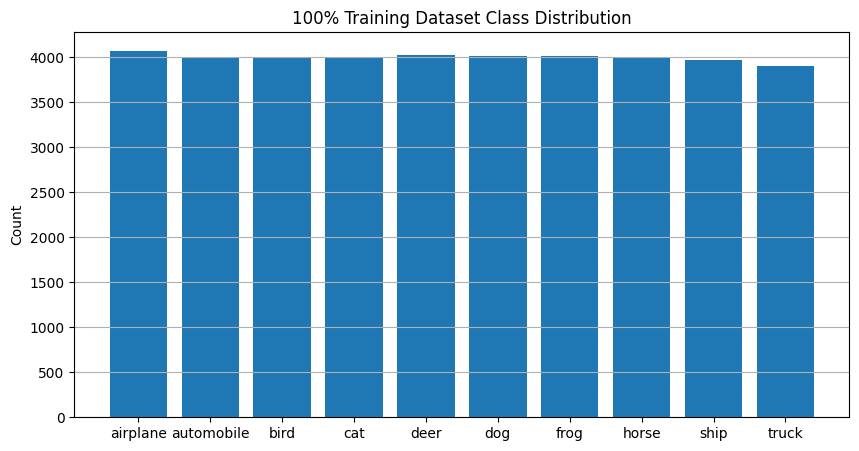

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - accuracy: 0.4657 - loss: 2.1024 - val_accuracy: 0.8020 - val_loss: 0.6364 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7656 - loss: 0.7918 - val_accuracy: 0.8331 - val_loss: 0.5333 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8142 - loss: 0.5932 - val_accuracy: 0.8537 - val_loss: 0.4594 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8406 - loss: 0.4966 - val_accuracy: 0.8698 - val_loss: 0.4018 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8633 - loss: 0.4263 - val_accuracy: 0.8812 - val_loss: 0.3665 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8786 - loss: 0.3682 - val_accuracy: 0.8896 - val_loss: 0.3383 - learning_rate: 1.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/st

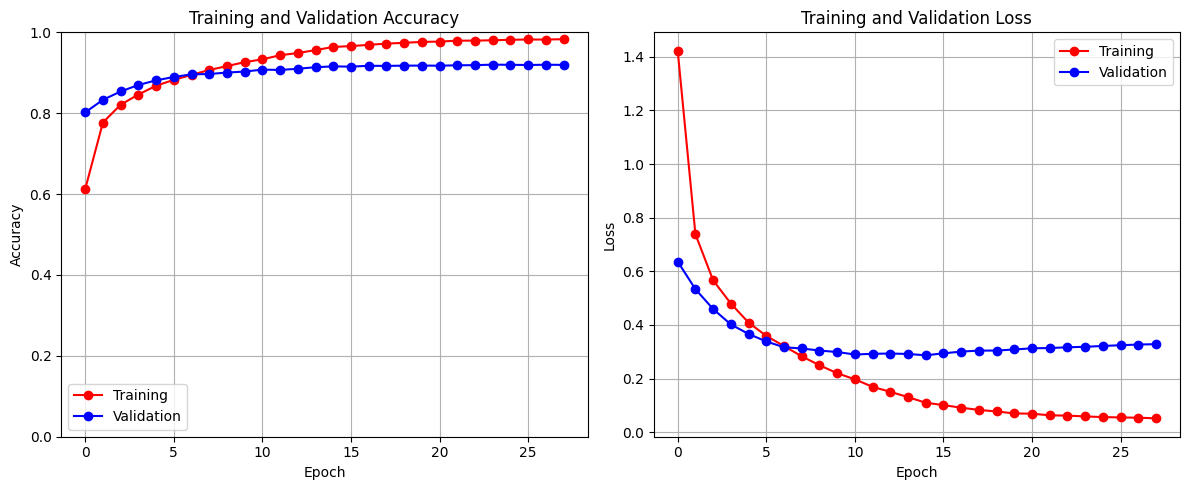

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9214 - loss: 0.3143
Test Accuracy: 0.9201


In [ ]:
classifier = create_classifier(num_classes)
labeled_train_ds_small = create_small_labeled_dataset(class_samples, num_classes, split=1)
analyze_dataset_distribution(labeled_train_ds_small, class_names, "100% Training Dataset Class Distribution")
history = train_classifier(classifier, labeled_train_ds_small, test_ds_processed, epochs=50)

## 100% with supervised model

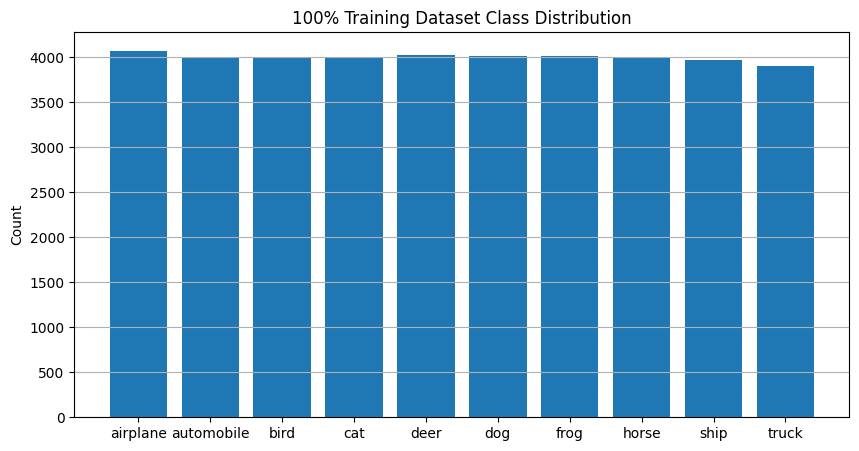

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 125ms/step - accuracy: 0.6671 - loss: 1.2705 - val_accuracy: 0.5115 - val_loss: 1.6530
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9126 - loss: 0.2880 - val_accuracy: 0.6736 - val_loss: 1.1398
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9474 - loss: 0.1631 - val_accuracy: 0.7444 - val_loss: 0.8465
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9649 - loss: 0.1123 - val_accuracy: 0.8424 - val_loss: 0.6020
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9752 - loss: 0.0761 - val_accuracy: 0.8551 - val_loss: 0.5594
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9781 - loss: 0.0703 - val_accuracy: 0.8735 - val_loss: 0.4904
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9790 - loss: 0.0627 - val_accuracy: 0.8724 - val_loss: 0.5532
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9838 - loss: 0.0520 -

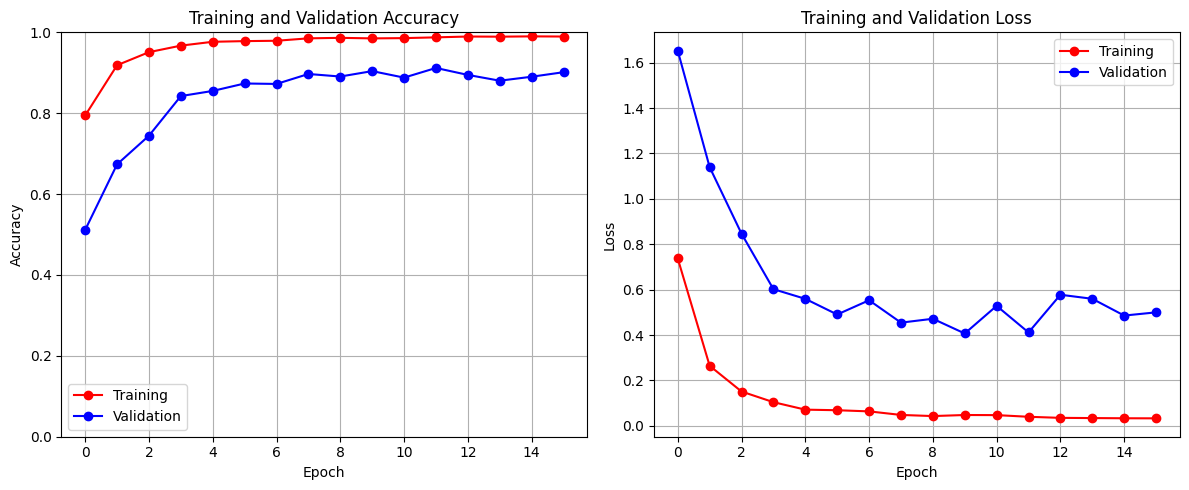

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9149 - loss: 0.4017
Test Accuracy: 0.9119


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

labeled_train_ds_large = create_small_labeled_dataset(class_samples, num_classes, split=1)
analyze_dataset_distribution(labeled_train_ds_large, class_names, "100% Training Dataset Class Distribution")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    labeled_train_ds_large,
    epochs=50,
    validation_data=test_ds_processed,
    callbacks=[early_stopping],
    verbose=1
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'r-o')
plt.plot(history.history['val_accuracy'], 'b-o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.legend(['Training', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-o')
plt.plot(history.history['val_loss'], 'b-o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(['Training', 'Validation'])

plt.tight_layout()
plt.show()

evaluation = model.evaluate(test_ds_processed, verbose=1)
print(f"Test Accuracy: {evaluation[1]:.4f}")

# Result

* 1%: **0.6676**
* 5%: **0.8012**
* 10%: **0.8293**
* 20%: **0.8645**
* 30%: **0.8781**
* 50%: **0.8962**
* 100%: **0.9201** (BEST)
* 100% (SM): **0.9119**

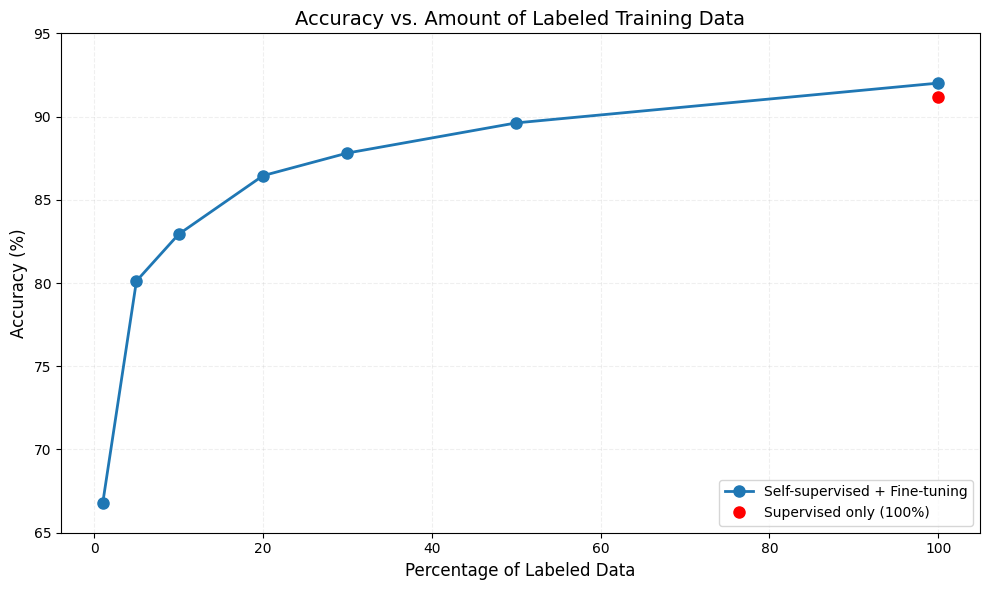

In [ ]:
def plot_accuracy_vs_labeled_data():
    percentages = [1, 5, 10, 20, 30, 50, 100]
    accuracies = [66.76, 80.12, 82.93, 86.45, 87.81, 89.62, 92.01]

    supervised_only_percentage = 100
    supervised_only_accuracy = 91.19

    plt.figure(figsize=(10, 6))

    plt.plot(percentages, accuracies, 'o-', color='#1f77b4', linewidth=2,
             markersize=8, label='Self-supervised + Fine-tuning')

    plt.plot(supervised_only_percentage, supervised_only_accuracy, 'o',
             color='red', markersize=8, label='Supervised only (100%)')

    plt.xlabel('Percentage of Labeled Data', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Accuracy vs. Amount of Labeled Training Data', fontsize=14)
    plt.grid(True, alpha=0.2, linestyle='--')

    plt.ylim(65, 95)

    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig("Accuracy_vs_labeled_data.png")

    plt.show()

plot_accuracy_vs_labeled_data()